In [1185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries

In [1186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS

In [1187]:
freezer = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Storm 2/freezer_data.csv")
outlets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Storm 2/outlets_data.csv")
sales = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Storm 2/sales_data.csv")
product = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Storm 2/product_data.csv")
week = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Storm 2/week_data.csv")

# **Data Cleaning**

Data cleaning of freezer

In [1188]:
freezer

,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours
0,ChillMaster,M001,55,2500
1,FreezeZone,M002,75,2800
2,CoolTech,M003,120,3200
3,mini CoolTech,M004,30,1800
4,IceBlast Pro,M005,150,3500
5,IceBlast,M006,65,2700
6,FreezeTech,M007,100,3000
7,FreezeTech 3.0,M008,25,1600
8,ChillTech,M009,80,2800
9,IceTech,M010,200,4500


In [1189]:
duplicates = freezer.duplicated().sum()
duplicates

0

In [1190]:
missing = freezer.isna().mean()
missing

Freezer Name                                      0.0
Model Number                                      0.0
Volume Capacity (Liters)                          0.0
Power and maitainance Cost (LKR) per 100 hours    0.0
dtype: float64

Data cleaning of product

In [1191]:
product

,pid,volume,product_name,price
0,IP1,0.2,Vanilla Mini Cone,100
1,IP2,0.2,Chocolate Petite Bar,90
2,IP3,0.2,Strawberry Tiny Cup,110
3,IP4,0.2,Mint Bite-size Pop,100
4,IP5,0.2,Butter Pecan Small Stick,100
5,BP1,1.0,Chocolate Fudge Big Scoop,1200
6,BP2,1.0,Moose Tracks Jumbo Cup,1100
7,BP3,1.0,Mint Chocolate Chip Family Pack,1150
8,BP4,1.0,Rocky Road Mega Tub,1000
9,BP5,1.0,Cookies and Cream Mega Tub,1100


In [1192]:
duplicates = product.duplicated().sum()
duplicates

0

In [1193]:
missing = product.isna().mean()
missing

pid             0.0
volume          0.0
product_name    0.0
price           0.0
dtype: float64

Data cleaning of week

In [1194]:
week

,Week,Start Date,End Date
0,Week 1,1/2/2023,1/8/2023
1,Week 2,1/9/2023,1/15/2023
2,Week 3,1/16/2023,1/22/2023
3,Week 4,1/23/2023,1/29/2023
4,Week 5,1/30/2023,2/5/2023
5,Week 6,2/6/2023,2/12/2023
6,Week 7,2/13/2023,2/19/2023
7,Week 8,2/20/2023,2/26/2023
8,Week 9,2/27/2023,3/5/2023
9,Week 10,3/6/2023,3/12/2023


In [1195]:
duplicates = week.duplicated().sum()
duplicates

0

In [1196]:
missing = week.isna().mean()
missing

Week          0.0
Start Date    0.0
End Date      0.0
dtype: float64

Data cleaning of outlets

In [1197]:
outlets

,Outlet_ID,area(sqft)
0,ID7203,5660
1,ID1878,4138
2,ID1740,5546
3,ID4366,5134
4,ID8358,4100
...,...,...
983,ID4119,3858
984,ID2978,3495
985,ID6549,1141
986,ID1210,3322


In [1198]:
duplicates = outlets.duplicated().sum()
duplicates

0

In [1199]:
missing = outlets.isna().mean()
missing

Outlet_ID     0.0
area(sqft)    0.0
dtype: float64

In [1200]:
num_unique_ids = outlets['Outlet_ID'].nunique()
num_unique_ids

951

In outlets data set there are 998 rows. But number of unique outlet_IDs are 951. That means there are multiple area values for some outlets. So, get a fair value replace that values from the mean value

In [1201]:
outlets = outlets.groupby('Outlet_ID')['area(sqft)'].mean()
outlets

Outlet_ID
ID1008    3387.0
ID1012    1931.0
ID1024    3127.0
ID1029    5294.0
ID1036    2584.0
           ...  
ID9960    4690.0
ID9971    3960.0
ID9973    4038.0
ID9979    4456.0
ID9980    5891.5
Name: area(sqft), Length: 951, dtype: float64

Data clean of sales

In [1202]:
sales

,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0
...,...,...,...,...,...
80995,ID8207,12,BP1,Chocolate Fudge Big Scoop,56.0
80996,ID8207,12,BP2,Moose Tracks Jumbo Cup,60.0
80997,ID8207,12,BP3,Mint Chocolate Chip Family Pack,51.0
80998,ID8207,12,BP4,Rocky Road Mega Tub,78.0


In [1203]:
duplicates = sales.duplicated().sum()
duplicates

10

In [1204]:
sales.drop_duplicates(inplace=True)

In [1205]:
missing = sales.isna().mean()
missing

Outlet_ID       0.0
week            0.0
pid             0.0
product_name    0.0
no_units        0.0
dtype: float64

In [1206]:
df = sales.iloc[:, :-1]
duplicates = df.duplicated().sum()
duplicates

3030

For a given week, no of sold units of a product for a given shop must be a unique value. But in this data set there are some multiple values for that. So, to get a fair value, replace them from mean value.

In [1207]:
sales = sales.groupby(['Outlet_ID','week','pid','product_name'])['no_units'].mean().reset_index()

We have to handle the outliers in each item in each outlet.

In [1208]:
threshold = 1.5

for shop in sales['Outlet_ID'].unique():
  trans = sales[sales['Outlet_ID'] == shop]
  for item in trans['pid'].unique():
      subset = trans[trans['pid'] == item]
      subset_mean = subset['no_units'].mean()
      q1 = subset['no_units'].quantile(0.25)
      q3 = subset['no_units'].quantile(0.75)
      iqr = q3 - q1
      lower_bound = subset_mean - threshold * iqr
      upper_bound = subset_mean + threshold * iqr
      outliers = subset[(subset['no_units'] < lower_bound) | (subset['no_units'] > upper_bound)]
      rep = subset['no_units'].median()
      outliers.loc[outliers['no_units'] < lower_bound, 'no_units'] = rep
      outliers.loc[outliers['no_units'] > upper_bound, 'no_units'] = rep
      sales.loc[outliers.index, 'no_units'] = outliers['no_units']
sales.describe()

,week,no_units
count,77960.000000,77960.000000
mean,6.504348,374.499451
std,3.453188,364.736369
min,1.000000,20.000000
25%,4.000000,81.000000
50%,7.000000,214.000000
75%,10.000000,599.000000
max,12.000000,1499.000000


# **Feature Engineering**

Let's merge necessary columns

In [1209]:
merge_to_sales = product[['pid','price','volume']]

In [1210]:
merged_sales = pd.merge(sales,merge_to_sales,on='pid')

In [1211]:
merged_sales['total_price']=merged_sales['no_units']*merged_sales['price'] 
merged_sales['total_volume']=merged_sales['no_units']*merged_sales['volume'] 

In [1212]:
daily_summed_sales = (merged_sales.groupby(['Outlet_ID','week'])[['total_volume','total_price']].sum()/7).reset_index() # daily sales of each shop

In [1213]:
daily_avged_sales = daily_summed_sales.groupby(['Outlet_ID'])[['total_volume','total_price']].mean().reset_index() # average of daily features of each shop

In [1214]:
weekly_avged_sales = daily_avged_sales.round(2)

In [1215]:
final_merged = pd.merge(outlets,weekly_avged_sales,on='Outlet_ID')

To get a rough idea about clusters, let's plot the features

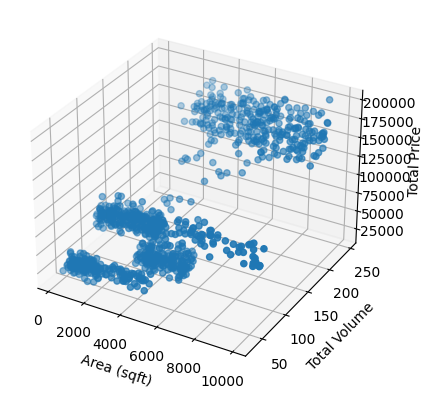

In [1216]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Add a scatter plot
ax.scatter(final_merged['area(sqft)'],final_merged['total_volume'], final_merged['total_price'])

# Set the axis labels
ax.set_xlabel('Area (sqft)')
ax.set_ylabel('Total Volume')
ax.set_zlabel('Total Price')

# Show the plot
plt.show()

In [1217]:
final_merged

,Outlet_ID,area(sqft),total_volume,total_price
0,ID1008,3387.0,78.58,39178.45
1,ID1012,1931.0,38.52,42925.60
2,ID1024,3127.0,82.65,91979.76
3,ID1029,5294.0,191.05,156663.63
4,ID1036,2584.0,106.49,76519.29
...,...,...,...,...
946,ID9960,4690.0,206.48,170637.86
947,ID9971,3960.0,86.86,43551.43
948,ID9973,4038.0,193.45,159426.55
949,ID9979,4456.0,81.08,40229.52


# **Clustering**

KMean

In [1218]:
final_merged_1 = final_merged

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

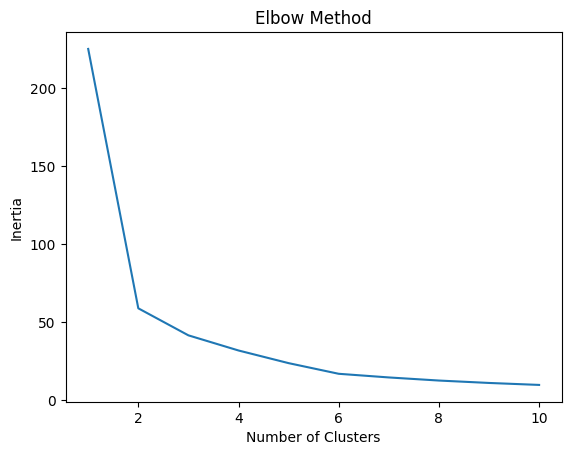

In [1219]:
# Normalize the data using StandardScaler
numeric_data = final_merged_1.drop(["Outlet_ID"], axis=1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Use the elbow method to choose the number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

KMean with K=2

In [1220]:
final_merged_0 = final_merged_1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


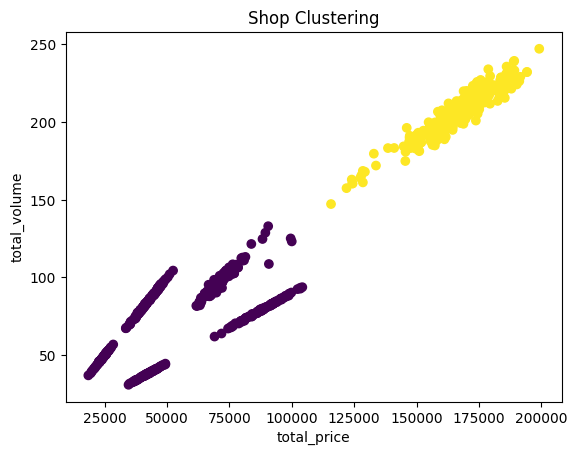

In [1221]:
# Apply k-means clustering with the chosen number of clusters
best_k = 2 # choose the elbow point based on the plot
kmeans_0 = KMeans(n_clusters=best_k, random_state=42)
labels_0 = kmeans_0.fit_predict(scaled_data)

# Add the cluster labels_0 to the numeric data
numeric_data["cluster_label"] = labels_0

# Merge the non-numeric columns with the clustered data based on the unique identifier column
final_merged_0 = pd.merge(final_merged_0[["Outlet_ID"]], numeric_data, left_index=True, right_index=True)


# Visualize the clusters using a scatter plot
plt.scatter(final_merged_0['total_price'], final_merged_0['total_volume'], c=final_merged_0['cluster_label'])
plt.xlabel('total_price')
plt.ylabel('total_volume')
plt.title('Shop Clustering')
plt.show()

In [1222]:
# evaluate model using metrics
inertia = kmeans_0.inertia_
silhouette = silhouette_score(scaled_data, labels_0)
davies_bouldin = davies_bouldin_score(scaled_data, labels_0)
calinski_harabasz = calinski_harabasz_score(scaled_data, labels_0)

# print results
print("Inertia: ", inertia)
print("Silhouette Coefficient: ", silhouette)
print("Davies-Bouldin Index: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)

Inertia:  58.91044878656915
Silhouette Coefficient:  0.6630528004082175
Davies-Bouldin Index:  0.48285786010055765
Calinski-Harabasz Index:  2679.240136113987


KMean with K=6

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


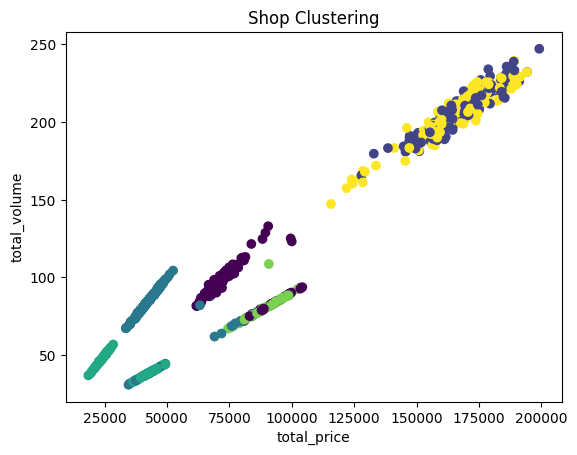

In [1223]:
# Apply k-means clustering with the chosen number of clusters
best_k = 6 # choose the elbow point based on the plot
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the numeric data
numeric_data["cluster_label"] = labels

# Merge the non-numeric columns with the clustered data based on the unique identifier column
final_merged_1 = pd.merge(final_merged_1[["Outlet_ID"]], numeric_data, left_index=True, right_index=True)


# Visualize the clusters using a scatter plot
plt.scatter(final_merged_1['total_price'], final_merged_1['total_volume'], c=final_merged_1['cluster_label'])
plt.xlabel('total_price')
plt.ylabel('total_volume')
plt.title('Shop Clustering')
plt.show()

In [1224]:


# evaluate model using metrics
inertia = kmeans.inertia_
silhouette = silhouette_score(scaled_data, labels)
davies_bouldin = davies_bouldin_score(scaled_data, labels)
calinski_harabasz = calinski_harabasz_score(scaled_data, labels)

# print results
print("Inertia: ", inertia)
print("Silhouette Coefficient: ", silhouette)
print("Davies-Bouldin Index: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)

Inertia:  16.92341310598607
Silhouette Coefficient:  0.48082521117871235
Davies-Bouldin Index:  0.7581373184170888
Calinski-Harabasz Index:  2326.3359063597754


Hierarchuical

In [1225]:
final_merged_2 = final_merged

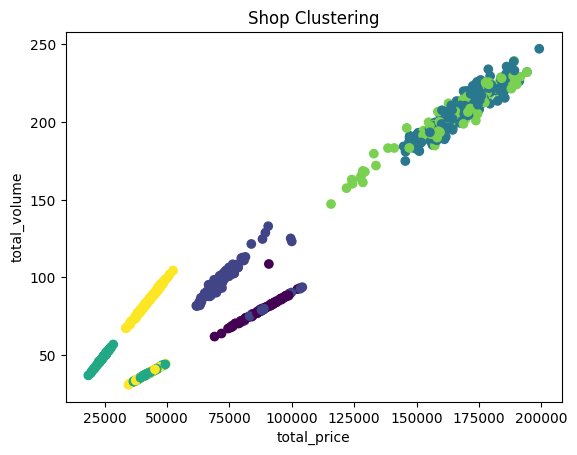

Silhouette Coefficient:  0.4787414761738219
Davies-Bouldin Index:  0.7717521211611965
Calinski-Harabasz Index:  2207.121414352739


In [1226]:


# Normalize the data using MinMaxScaler
numeric_data = final_merged_2.drop(["Outlet_ID"], axis=1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply hierarchical clustering with the chosen number of clusters
best_k = 6 # choose the number of clusters based on domain knowledge or visualization
hierarchical = AgglomerativeClustering(n_clusters=best_k)
labels = hierarchical.fit_predict(scaled_data)

# Add the cluster labels to the numeric data
numeric_data["cluster_label"] = labels

# Merge the non-numeric columns with the clustered data based on the unique identifier column
final_merged_2 = pd.merge(final_merged_2[["Outlet_ID"]], numeric_data, left_index=True, right_index=True)

# Visualize the clusters using a scatter plot
plt.scatter(final_merged_2['total_price'], final_merged_2['total_volume'], c=final_merged_2['cluster_label'])
plt.xlabel('total_price')
plt.ylabel('total_volume')
plt.title('Shop Clustering')
plt.show()

# evaluate model using metrics
silhouette = silhouette_score(scaled_data, labels)
davies_bouldin = davies_bouldin_score(scaled_data, labels)
calinski_harabasz = calinski_harabasz_score(scaled_data, labels)

# print results
print("Silhouette Coefficient: ", silhouette)
print("Davies-Bouldin Index: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)


optics

In [1227]:
final_merged_3 = final_merged

In [1228]:


# Create an instance of the OPTICS clustering algorithm
optics = OPTICS(min_samples=2, xi=.05)

# Fit the model to the data
numeric_data = final_merged_3.drop(["Outlet_ID"], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(numeric_data)

labels = optics.fit_predict(X)
numeric_data["cluster_label"] = labels
final_merged_3 = pd.merge(final_merged_3[["Outlet_ID"]], numeric_data, left_index=True, right_index=True)
# Get the cluster labels for each data point

# Calculate the inertia
inertia = np.sum((X - np.mean(X, axis=0)) ** 2)

# Calculate the silhouette score
silhouette = silhouette_score(X, labels)

# Calculate the Davies-Bouldin score
davies_bouldin = davies_bouldin_score(X, labels)

# Calculate the Calinski-Harabasz score
calinski_harabasz = calinski_harabasz_score(X, labels)

# Print the results
print("Inertia: ", inertia)
print("Silhouette score: ", silhouette)
print("Davies-Bouldin score: ", davies_bouldin)
print("Calinski-Harabasz score: ", calinski_harabasz)


Inertia:  225.22787642140943
Silhouette score:  0.18325545962781328
Davies-Bouldin score:  1.3081471233940476
Calinski-Harabasz score:  8.590562683664231


Find best freezer

Best values got from KMean with k=6. So, use it for future calculations

In [1229]:
# usingk_means clustred dataset for furthur steps
final_merged = final_merged_1

In [1230]:
# taking a copy of clustered dataset and viewing
predict_data_set = final_merged.copy()
predict_data_set

,Outlet_ID,area(sqft),total_volume,total_price,cluster_label
0,ID1008,3387.0,78.58,39178.45,2
1,ID1012,1931.0,38.52,42925.60,3
2,ID1024,3127.0,82.65,91979.76,0
3,ID1029,5294.0,191.05,156663.63,5
4,ID1036,2584.0,106.49,76519.29,0
...,...,...,...,...,...
946,ID9960,4690.0,206.48,170637.86,5
947,ID9971,3960.0,86.86,43551.43,2
948,ID9973,4038.0,193.45,159426.55,5
949,ID9979,4456.0,81.08,40229.52,2


In [1251]:
predict_data_set.groupby('cluster_label').describe()

area(sqft)                                                     \
                   count         mean          std     min      25%     50%   
cluster_label                                                                 
0                  241.0  2460.041494  1056.225810   502.0  1547.00  2473.0   
1                  150.0  7918.643333  1076.072668  6290.0  6988.50  7820.5   
2                  212.0  4461.018868   770.422866  3043.0  3886.00  4365.5   
3                  138.0  1381.376812   781.817676   123.0   728.00  1357.0   
4                   64.0  7321.781250  1514.147499  5142.0  6064.25  6966.0   
5                  146.0  4666.691781  1001.074223  2342.5  3808.25  4719.0   

                               total_volume              ...            \
                   75%     max        count        mean  ...       75%   
cluster_label                                            ...             
0              3336.00  4920.5        241.0   94.708257  ...  101.5100   
1              8855.75  9950.0        150.0  207.548467  ...  217.0325   
2              5027.75  5953.0        212.0   76.126179  ...   87.1025   
3              1828.25  3379.0        138.0   43.237609  ...   48.6650   
4              8744.50  9896.0         64.0   80.930000  ...   84.7375   
5              5522.75  6243.0        146.0  205.626986  ...  216.6575   

                      total_price                                          \
                  max       count           mean           std        min   
cluster_label                                                               
0              132.99       241.0   76153.539087   9521.826119   61690.00   
1              247.16       150.0  167919.247000  12550.402188  127914.46   
2              104.43       212.0   44324.178255   9633.287070   33405.71   
3               56.87       138.0   33097.968623   9601.230209   18388.81   
4              108.67        64.0   89431.095781   6359.202647   74412.50   
5              239.39       146.0  166158.181438  15230.122715  115715.42   

                                                                
                       25%         50%          75%        max  
cluster_label                                                   
0               69613.6900   73198.690   80236.6700  104207.74  
1              159157.1425  168251.960  176045.9850  199226.31  
2               39487.9475   41890.420   45499.6150   86054.76  
3               24171.4600   27942.470   42158.7825   49276.79  
4               85775.2950   90576.485   93988.7650  102277.08  
5              158369.5875  168735.955  175945.5075  194284.40  

[6 rows x 24 columns]

In [1252]:
predict_data_set.to_csv('predicted.csv', index=False)

In [1231]:
# taking weekly average of cluster of the coloumns total_volume and total_price
predict_data_set_1 = predict_data_set.groupby(['cluster_label'])[['total_volume','total_price']].mean()

In [1232]:
# rounding decimals to nearest 2 decimals
predict_data_set_1=predict_data_set_1.round(2)

In [1233]:
# calculating freezer cost per a day
freezer['cost_24_hours'] = freezer['Power and maitainance Cost (LKR) per 100 hours'] * 24/100

In [1234]:
#calculating average income of an outlet per liter
predict_data_set_1['income_per_liter']=predict_data_set_1['total_price']/predict_data_set_1['total_volume']

In [1235]:
# calculating expenses per liter in the respective freezer
freezer['expenses_per_liter'] = freezer['cost_24_hours']/freezer['Volume Capacity (Liters)']

In [1236]:
freezer

,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours,cost_24_hours,expenses_per_liter
0,ChillMaster,M001,55,2500,600.0,10.909091
1,FreezeZone,M002,75,2800,672.0,8.960000
2,CoolTech,M003,120,3200,768.0,6.400000
3,mini CoolTech,M004,30,1800,432.0,14.400000
4,IceBlast Pro,M005,150,3500,840.0,5.600000
5,IceBlast,M006,65,2700,648.0,9.969231
6,FreezeTech,M007,100,3000,720.0,7.200000
7,FreezeTech 3.0,M008,25,1600,384.0,15.360000
8,ChillTech,M009,80,2800,672.0,8.400000
9,IceTech,M010,200,4500,1080.0,5.400000


In [1237]:
predict_data_set_1

,total_volume,total_price,income_per_liter
cluster_label,,,
0,94.71,76153.54,804.070742
1,207.55,167919.25,809.054445
2,76.13,44324.18,582.216997
3,43.24,33097.97,765.447965
4,80.93,89431.10,1105.042629
5,205.63,166158.18,808.044449


In [1238]:
# debugging and testing purpose code segment
predict_data_set_1 = predict_data_set.groupby(['cluster_label'])[['total_volume','total_price']].mean()
predict_data_set_1=predict_data_set_1.round(2)
predict_data_set_1['income_per_liter']=predict_data_set_1['total_price']/predict_data_set_1['total_volume']

In [1239]:
predict_data_set_1

,total_volume,total_price,income_per_liter
cluster_label,,,
0,94.71,76153.54,804.070742
1,207.55,167919.25,809.054445
2,76.13,44324.18,582.216997
3,43.24,33097.97,765.447965
4,80.93,89431.10,1105.042629
5,205.63,166158.18,808.044449


In [1240]:
# Calculating net profit of the clusters for all the freezers

# iterating over freezers
for index,row in freezer.iterrows():
  model = row['Model Number']
  netProfit = "Net profit for Model "+model
  loss = "loss for Model "+model
  v = row['Volume Capacity (Liters)']
  expenses = row['expenses_per_liter']

  # seperating the rows where total_voloume >= freezer_volume
  predict_data_set_lower = predict_data_set_1[predict_data_set_1["total_volume"]>=v]
  # seperating the rows where total_voloume < freezer_volume
  predict_data_set_higher = predict_data_set_1[predict_data_set_1["total_volume"]<v]

  predict_data_set_lower[netProfit] = v*(predict_data_set_lower["income_per_liter"]-expenses)-(predict_data_set_lower['total_volume']-v)*(predict_data_set_lower["income_per_liter"]-expenses)

  predict_data_set_higher[netProfit]=predict_data_set_higher['total_volume']*(predict_data_set_higher["income_per_liter"]-expenses)-(v-predict_data_set_higher['total_volume'])*(expenses)

  # concatanating dataframes
  predict_data_set_1 = pd.concat([predict_data_set_lower, predict_data_set_higher], axis=0)

<ipython-input-1240-3899688ca3e0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_set_lower[netProfit] = v*(predict_data_set_lower["income_per_liter"]-expenses)-(predict_data_set_lower['total_volume']-v)*(predict_data_set_lower["income_per_liter"]-expenses)
<ipython-input-1240-3899688ca3e0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data_set_higher[netProfit]=predict_data_set_higher['total_volume']*(predict_data_set_higher["income_per_liter"]-expenses)-(v-predict_data_set_highe

In [1241]:
predict_data_set_1

,total_volume,total_price,income_per_liter,Net profit for Model M001,Net profit for Model M002,Net profit for Model M003,Net profit for Model M004,Net profit for Model M005,Net profit for Model M006,Net profit for Model M007,Net profit for Model M008,Net profit for Model M009,Net profit for Model M010
cluster_label,,,,,,,,,,,,,
1,207.55,167919.25,809.054445,-77859.079263,-46045.435293,26046.136731,-117251.263317,74279.363414,-61969.058341,-6054.001058,-125046.559764,-38071.118846,154663.297885
5,205.63,166158.18,808.044449,-76230.054272,-44453.067885,27552.519704,-115578.441074,75726.682630,-60358.428737,-4508.754247,-123365.480762,-36487.776197,156010.001507
0,94.71,76153.54,804.070742,12127.441649,43961.672940,75385.540000,-27409.471464,75313.540000,28023.842341,75433.540000,-35263.257287,51949.342763,75073.540000
4,80.93,89431.10,1105.042629,31806.461965,75706.427215,88663.100000,-22827.150234,88591.100000,53735.251672,88711.100000,-33703.883728,86711.532709,88351.100000
2,76.13,44324.18,582.216997,19350.198787,42346.494386,43556.180000,-9158.888166,43484.180000,30826.987180,43604.180000,-14811.973338,43652.180000,43244.180000
3,43.24,33097.97,765.447965,32497.970000,32425.970000,32329.970000,12587.563891,32257.970000,32449.970000,32377.970000,5070.594642,32425.970000,32017.970000


Allocate freezers

In [1242]:
# drop the coloumns used for calculation
predict_data_set_final = predict_data_set_1.drop(columns=['total_volume','total_price','income_per_liter'])

In [1243]:
# Selecting the best valued freezer
predict_data_set_final['max_col']=predict_data_set_final.idxmax(axis=1).str.split().str[-1]

In [1244]:
predict_data_set_final

,Net profit for Model M001,Net profit for Model M002,Net profit for Model M003,Net profit for Model M004,Net profit for Model M005,Net profit for Model M006,Net profit for Model M007,Net profit for Model M008,Net profit for Model M009,Net profit for Model M010,max_col
cluster_label,,,,,,,,,,,
1,-77859.079263,-46045.435293,26046.136731,-117251.263317,74279.363414,-61969.058341,-6054.001058,-125046.559764,-38071.118846,154663.297885,M010
5,-76230.054272,-44453.067885,27552.519704,-115578.441074,75726.682630,-60358.428737,-4508.754247,-123365.480762,-36487.776197,156010.001507,M010
0,12127.441649,43961.672940,75385.540000,-27409.471464,75313.540000,28023.842341,75433.540000,-35263.257287,51949.342763,75073.540000,M007
4,31806.461965,75706.427215,88663.100000,-22827.150234,88591.100000,53735.251672,88711.100000,-33703.883728,86711.532709,88351.100000,M007
2,19350.198787,42346.494386,43556.180000,-9158.888166,43484.180000,30826.987180,43604.180000,-14811.973338,43652.180000,43244.180000,M009
3,32497.970000,32425.970000,32329.970000,12587.563891,32257.970000,32449.970000,32377.970000,5070.594642,32425.970000,32017.970000,M001


In [1245]:
# making a final data set ready to be plotted
graph_data_set = predict_data_set_final.rename(columns={
      "Net profit for Model M001":"M001",
      "Net profit for Model M002":"M002",
      "Net profit for Model M003":"M003",
      "Net profit for Model M004":"M004",
      "Net profit for Model M005":"M005",
      "Net profit for Model M006":"M006",
      "Net profit for Model M007":"M007",
      "Net profit for Model M008":"M008",
      "Net profit for Model M009":"M009",
      "Net profit for Model M010":"M010"
  })

In [1246]:
graph_data_set

,M001,M002,M003,M004,M005,M006,M007,M008,M009,M010,max_col
cluster_label,,,,,,,,,,,
1,-77859.079263,-46045.435293,26046.136731,-117251.263317,74279.363414,-61969.058341,-6054.001058,-125046.559764,-38071.118846,154663.297885,M010
5,-76230.054272,-44453.067885,27552.519704,-115578.441074,75726.682630,-60358.428737,-4508.754247,-123365.480762,-36487.776197,156010.001507,M010
0,12127.441649,43961.672940,75385.540000,-27409.471464,75313.540000,28023.842341,75433.540000,-35263.257287,51949.342763,75073.540000,M007
4,31806.461965,75706.427215,88663.100000,-22827.150234,88591.100000,53735.251672,88711.100000,-33703.883728,86711.532709,88351.100000,M007
2,19350.198787,42346.494386,43556.180000,-9158.888166,43484.180000,30826.987180,43604.180000,-14811.973338,43652.180000,43244.180000,M009
3,32497.970000,32425.970000,32329.970000,12587.563891,32257.970000,32449.970000,32377.970000,5070.594642,32425.970000,32017.970000,M001


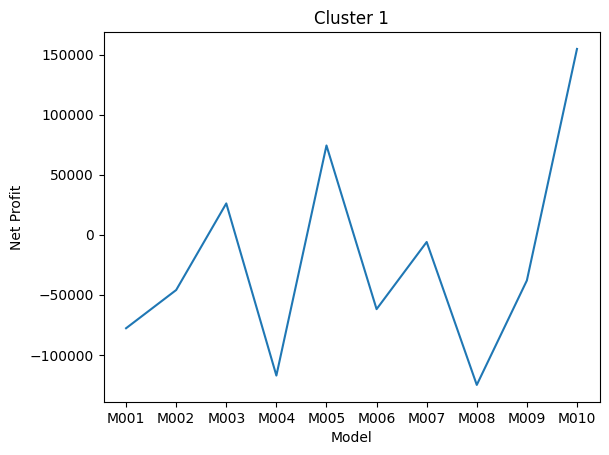

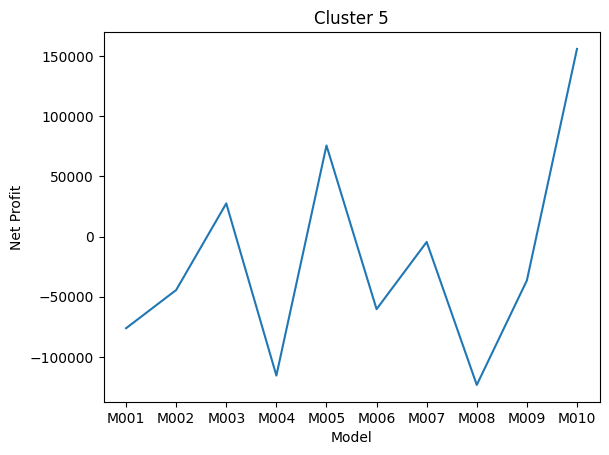

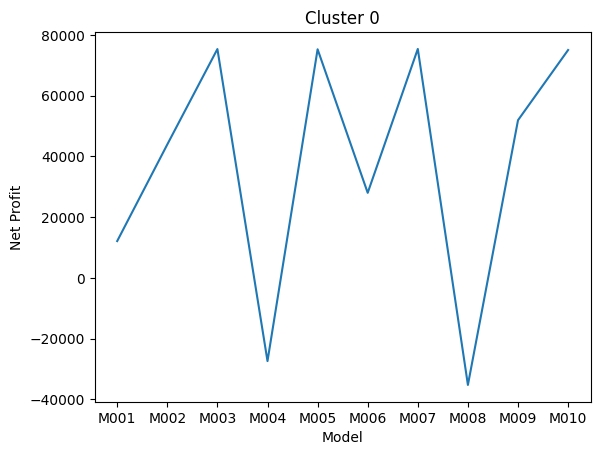

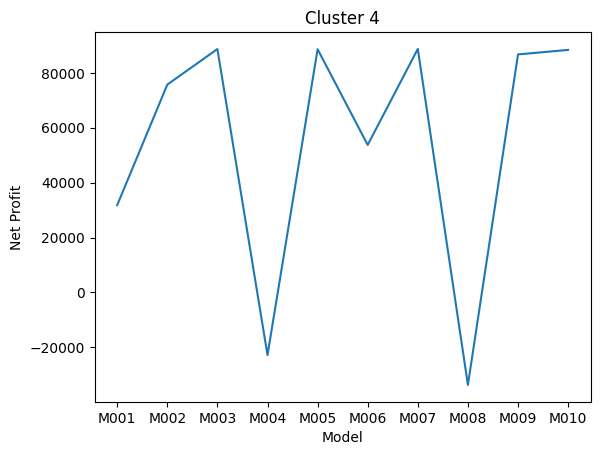

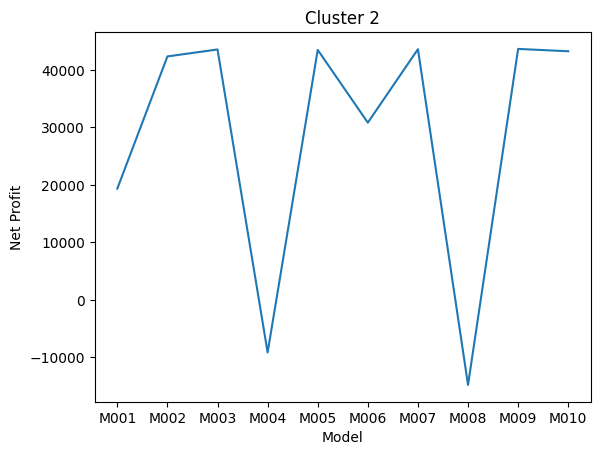

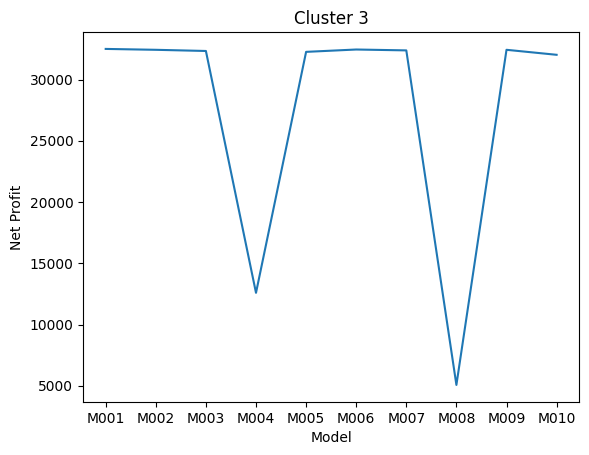

In [1247]:
# ploting the grpahs


# loop through each row in the dataframe
for index, row in graph_data_set.iterrows():
    # extract the net profit values and plot them as a line graph
    net_profit_values = row[:-1]
    plt.plot(net_profit_values)
    plt.title(f"Cluster {index}")  # set the title of the plot
    plt.xlabel("Model")  # set the x-axis label
    plt.ylabel("Net Profit")  # set the y-axis label
    plt.xticks(range(len(net_profit_values)), net_profit_values.index)  # set the x-tick labels
    plt.show()  # display the plot

In [1248]:
# Creating a output view
output_data_set = predict_data_set_final.drop(columns=["Net profit for Model M001","Net profit for Model M002",'Net profit for Model M003','Net profit for Model M004',
                                                       'Net profit for Model M005','Net profit for Model M006','Net profit for Model M007','Net profit for Model M008',
                                                       'Net profit for Model M009','Net profit for Model M010'])

In [1249]:
# showing the view
output_data_set

,max_col
cluster_label,
1,M010
5,M010
0,M007
4,M007
2,M009
3,M001
